# Machine Learning
# TP4: Introduction to Neural Networks

## Part 1: More Gradient Descents

We will study several gradient descent methods, including the ordinary gradient descent and gradient descents with first and second moments.

In [1]:
#Make plots static
%matplotlib inline

In [4]:
import numpy as np

In [2]:
#Make 3D plots
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.colors import LogNorm

In [3]:
# To display html as actual html
from IPython.display import HTML

### Surfaces

We will use the following plotting tools. First some handy functions:

In [87]:
def plot_surface(x, y, z, azim=-60, elev=40, dist=10, cmap="RdYlBu_r"):

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    plot_args = {'rstride': 1, 'cstride': 1, 'cmap':cmap,
             'linewidth': 20, 'antialiased': True,
             'vmin': -2, 'vmax': 2}
    ax.plot_surface(x, y, z, **plot_args)
    ax.view_init(azim=azim, elev=elev)
    ax.dist=dist
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    ax.set_zlim(-2, 2)
    
    plt.xticks([-1, -0.5, 0, 0.5, 1], ["-1", "-1/2", "0", "1/2", "1"])
    plt.yticks([-1, -0.5, 0, 0.5, 1], ["-1", "-1/2", "0", "1/2", "1"])
    ax.set_zticks([-2, -1, 0, 1, 2])
    ax.set_zticklabels(["-2", "-1", "0", "1", "2"])
    
    ax.set_xlabel("x", fontsize=18)
    ax.set_ylabel("y", fontsize=18)
    ax.set_zlabel("z", fontsize=18)
    return fig, ax;

def overlay_trajectory_quiver(ax,obj_func,trajectory, color='k'):
    xs=trajectory[:,0]
    ys=trajectory[:,1]
    zs=obj_func(xs,ys)
    ax.quiver(xs[:-1], ys[:-1], zs[:-1], xs[1:]-xs[:-1], ys[1:]-ys[:-1],zs[1:]-zs[:-1],color=color,arrow_length_ratio=0.3)
    return ax;

def overlay_trajectory(ax,obj_func,trajectory,label,color='k'):
    xs=trajectory[:,0]
    ys=trajectory[:,1]
    zs=obj_func(xs,ys)
    ax.plot(xs,ys,zs, color, label=label)
    return ax;
    
def overlay_trajectory_contour_M(ax, trajectory, label, color='k', lw=2):
    xs = trajectory[:,0]
    ys = trajectory[:,1]
    ax.plot(xs, ys, color, label=label, lw=lw)
    ax.plot(xs[-1], ys[-1], color+'>', markersize=14)
    return ax;

def overlay_trajectory_contour(ax, trajectory, label, color='k',lw=2):
    xs = trajectory[:,0]
    ys = trajectory[:,1]
    ax.plot(xs, ys, color, label=label,lw=lw)
    return ax;

def distance_to_min(ax, trajectory, minimum, label, color='k', lw=2):
    x0 = minimum[0]
    y0 = minimum[1]
    ds = np.sqrt((trajectory[:, 0]-x0)**2 + (trajectory[:, 1]-y0)**2)
    ts = np.arange(len(trajectory))
    ax.plot(ts, ds, color, label=label, lw=lw)

then let's define the surfaces:

 - A saddle point

In [6]:
#Define monkey saddle and gradient

def monkey_saddle(x,y):
    return x**3 - 3*x*y**2

def grad_monkey_saddle(params):
    x=params[0]
    y=params[1]
    grad_x= 3*x**2-3*y**2
    grad_y= -6*x*y
    return [grad_x,grad_y]

- A quadratic minimum

In [147]:
# Define minima_surface

def minima_surface(x, y, a=1, b=1):
    return a*x**2+b*y**2-1

def grad_minima_surface(pt, a=1, b=1):
    x=pt[0]
    y=pt[1]
    grad_x= 2*a*x
    grad_y= 2*b*y
    return [grad_x,grad_y]

 - Beales's function

In [227]:
# Define Beale's function

def beales_function(x, y):
    return np.square(1.5-x+x*y)+np.square(2.25-x+x*y*y)+np.square(2.625-x+x*y**3)
    return f

def grad_beales_function(params):
    x=params[0]
    y=params[1]
    grad_x=2*(1.5-x+x*y)*(-1+y)+2*(2.25-x+x*y**2)*(-1+y**2)+2*(2.625-x+x*y**3)*(-1+y**3)
    grad_y=2*(1.5-x+x*y)*x+4*(2.25-x+x*y**2)*x*y+6*(2.625-x+x*y**3)*x*y**2
    return [grad_x,grad_y]

def contour_beales_function():
    #plot beales function
    x, y = np.meshgrid(np.arange(-4.5, 4.5, 0.2), np.arange(-4.5, 4.5, 0.2))
    fig, ax = plt.subplots(figsize=(10, 6))
    z=beales_function(x,y)
    cax = ax.contour(x, y, z, levels=np.logspace(0, 5, 35), norm=LogNorm(), cmap="RdYlBu_r")
    ax.plot(3, 0.5, 'r*', markersize=10)
    ax.text(3, 0.5, s="min", verticalalignment='bottom', horizontalalignment='center')

    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')

    ax.set_xlim((-4.5, 4.5))
    ax.set_ylim((-4.5, 4.5))
    
    return fig,ax

Let's plot them:

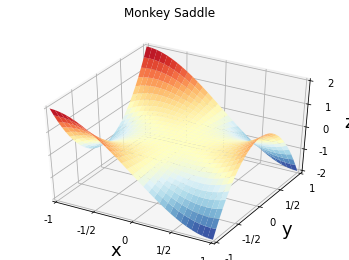

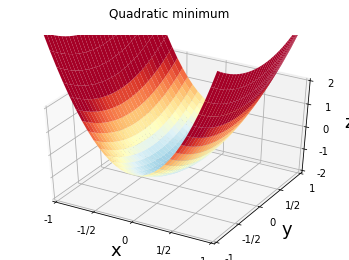

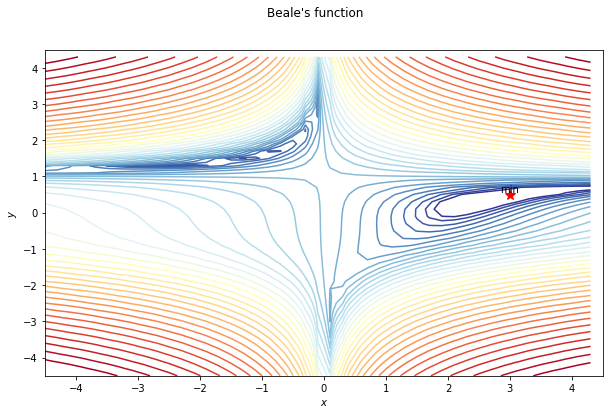

In [228]:
#Make plots of surfaces
plt.close() # closes previous plots
x, y = np.mgrid[-1:1:31j, -1:1:31j]
fig1,ax1=plot_surface(x,y,monkey_saddle(x,y))
fig1.suptitle("Monkey Saddle")
fig2,ax2=plot_surface(x,y,minima_surface(x,y,5))
fig2.suptitle("Quadratic minimum")
#Contour plot of Beale's Function
fig3,ax3 =contour_beales_function()
fig3.suptitle("Beale's function")
plt.show()

### Simple Gradient Descents

 - Ordinary Gradient Descent (OGD)

In [141]:
#Mean-gradient based methods
def gd(grad, init, n_epochs=1000, eta=10**-4, noise_strength=0):
    #This is a simple optimizer
    params=np.array(init)
    param_traj=np.zeros([n_epochs+1,2])
    param_traj[0,]=init[:2]
    v=0;
    for j in range(n_epochs):
        noise=noise_strength*np.random.randn(params.size)
        v=eta*(np.array(grad(params))+ noise)
        params=params-v
        param_traj[j+1,]=params
    return param_traj

 - Gradient Descent with momentum (GDM)

The momentum part adresses the issue of the OGD getting stuck in small local minima. By keeping a 'memory' of the previous gradients, we hope that the method will go through small dips in the cost function landscape.

In [140]:
def gd_with_mom(grad, init, n_epochs=5000, eta=10**-4, 
                gamma=0.9, noise_strength=0):
    params=np.array(init)
    param_traj=np.zeros([n_epochs+1,2])
    param_traj[0,]=init
    v=0
    for j in range(n_epochs):
        noise=noise_strength*np.random.randn(params.size)
        v=gamma*v+eta*(np.array(grad(params))+noise)
        params=params-v
        param_traj[j+1,]=params
    return param_traj

 - Nesterov Accelerated Gradient (NAG)

Same idea except that the gradient is computed each time at the point where GDM would lead us instead of the current location.

In [142]:
def NAG(grad, init, n_epochs=5000, eta=10**-4, gamma=0.9, noise_strength=0):
    params=np.array(init)
    param_traj=np.zeros([n_epochs+1,2])
    param_traj[0,]=init
    v=0
    for j in range(n_epochs):
        noise=noise_strength*np.random.randn(params.size)
        params_nesterov=params-gamma*v
        v=gamma*v+eta*(np.array(grad(params_nesterov))+noise)
        params=params-v
        param_traj[j+1,]=params
    return param_traj

### Experiments

- Stuying the learning rate in the simplest GD:

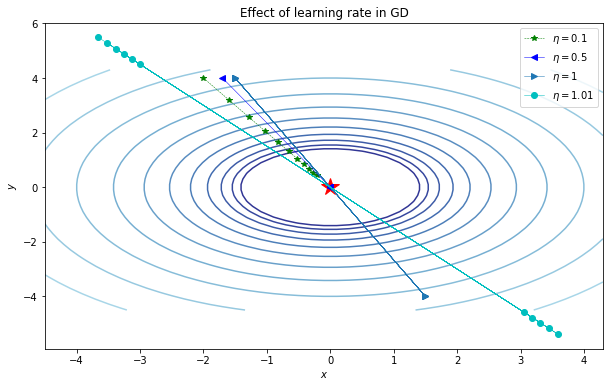

In [150]:
# Plot 
plt.close()

x, y = np.meshgrid(np.arange(-4.5, 4.5, 0.2), 
                   np.arange(-4.5, 4.5, 0.2))
a, b = 1.0, 1.0
grad_quadra = lambda param : grad_minima_surface(param, a, b)

z = np.abs(minima_surface(x, y, a, b))
fig, ax = plt.subplots(figsize=(10, 6))
ax.contour(x, y, z, levels=np.logspace(0.0, 5, 35), 
           norm=LogNorm(), cmap="RdYlBu_r")
ax.plot(0,0, 'r*', markersize=18)

init1 = [-2,4]
init2 = [-1.7,4]
init3 = [-1.5,4]
init4 = [-3,4.5]
eta1 = 0.1
eta2 = 0.5
eta3 = 1 
eta4 = 1.01

gd_plot = lambda init_, eta_: gd(grad_quadra, init_, n_epochs=10, eta=eta_)

gd_1=gd_plot(init1, eta1)
gd_2=gd_plot(init2, eta2)
gd_3=gd_plot(init3, eta3)
gd_4=gd_plot(init4, eta4)

overlay_trajectory_contour(ax, gd_1, '$\eta=$%s'% eta1,
                           'g--*', lw=0.5)
overlay_trajectory_contour(ax, gd_2, '$\eta=$%s'% eta2, 
                           'b-<', lw=0.5)
overlay_trajectory_contour(ax, gd_3, '$\eta=$%s'% eta3,
                           '->', lw=0.5)
overlay_trajectory_contour(ax, gd_4, '$\eta=$%s'% eta4,
                           'c-o', lw=0.5)

plt.title("Effect of learning rate in GD")
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.legend()

Qualitative behaviors with respect to the learning rate $\eta$:
 - ($\eta = 0.1$) the method converges with many small steps;
 - ($\eta = 0.5$) the method converges with one step only -- the fastest;
 - ($\eta = 1.$) the method oscillates around the minimum but does not converge;
 - ($\eta = 1.01$) the method oscillates around the minimum and diverges!

Conclusion: Choosing the learning rate parameter wisely is paramount!

 - Add anisotropy

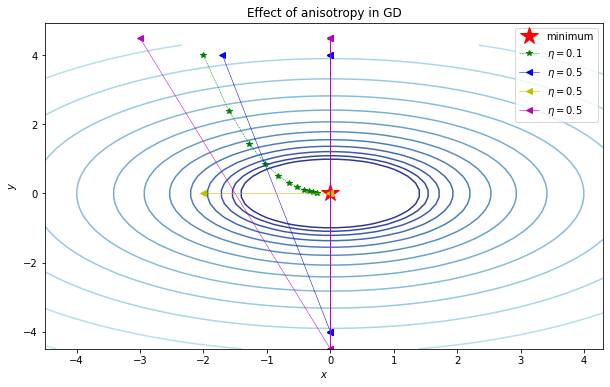

In [154]:
# Plot with an anisotropic surface
plt.close()

x, y = np.meshgrid(np.arange(-4.5, 4.5, 0.2), 
                   np.arange(-4.5, 4.5, 0.2))
a, b = 1.0, 2.0
grad_quadra = lambda param : grad_minima_surface(param, a, b)

z = np.abs(minima_surface(x, y, a, b))
fig, ax = plt.subplots(figsize=(10, 6))
ax.contour(x, y, z, levels=np.logspace(0.0, 5, 35), 
           norm=LogNorm(), cmap="RdYlBu_r")
ax.plot(0,0, 'r*', markersize=18, label='minimum')

init1 = [-2, 4]
init2 = [-1.7, 4]
init3 = [-2, 0]
init4 = [-3, 4.5]
eta1 = 0.1
eta2 = 0.5
eta3 = 1 
eta4 = 1.01

gd_plot = lambda init_, eta_: gd(grad_quadra, init_, n_epochs=10, eta=eta_)

gd_1=gd_plot(init1, eta1)
gd_2=gd_plot(init2, eta2)
gd_3=gd_plot(init3, eta2)
gd_4=gd_plot(init4, eta2)

overlay_trajectory_contour(ax, gd_1, '$\eta=$%s'% eta1,
                           'g--*', lw=0.5)
overlay_trajectory_contour(ax, gd_2, '$\eta=$%s'% eta2, 
                           'b-<', lw=0.5)
overlay_trajectory_contour(ax, gd_3, '$\eta=$%s'% eta2, 
                           'y-<', lw=0.5)
overlay_trajectory_contour(ax, gd_4, '$\eta=$%s'% eta2, 
                           'm-<', lw=0.5)

plt.title("Effect of anisotropy in GD")
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.legend()

We only consider the two learning rates that did converge previously. The gradient descent with small steps still converge, still slowly. The behavior of the other one, which used to reach the minimum with one step only, now depends on the starting point. On the $x$ axis, the curvature has not changed and the method converges again. However when the starting point leaves the $Ox$ axis, the learning rate turns out to be too large and the method oscillates around the minimum without converging.

So not only does the learning rate need to be adjusted, but this tuning really depends on the local landscape.

- **Comparing ordinary GD with methods using the first momentum:**

In [155]:
a, b = 1.0, 1.0
grad_quadra = lambda param : grad_minima_surface(param, a, b)

Text(0.5, 1.0, 'Comparison of first-moment GD (with $\\eta= 0.1$)')

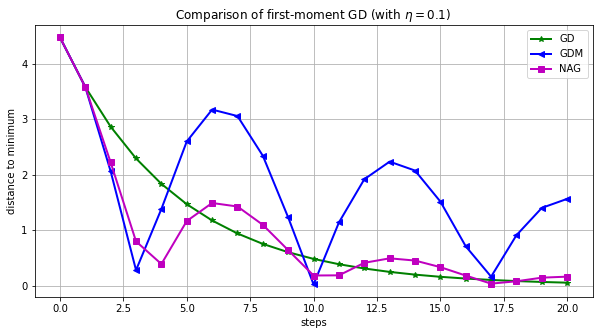

In [157]:
# Comparing GD with CM and NAG (for learning rate=eta1)
plt.close()

fig1, ax1 = plt.subplots(figsize=(10, 5))

# using eta1: GD converges slowly
gd_1 = gd(grad_quadra, init1, n_epochs=20, eta=eta1)
gd_2 = gd_with_mom(grad_quadra, init1, n_epochs=20, eta=eta1)
gd_3 = NAG(grad_quadra, init1, n_epochs=20, eta=eta1)
distance_to_min(ax1, gd_1, (0., 0.),'GD','g-*')
distance_to_min(ax1, gd_2, (0., 0.),'GDM','b-<')
distance_to_min(ax1, gd_3, (0., 0.),'NAG','m-s')

plt.grid()
plt.legend()
plt.xlabel("steps")
plt.ylabel("distance to minimum")
plt.title("Comparison of first-moment GD (with $\eta= %s$)" % eta1)

For a learning rate $\eta=0.1$, the OGD converges with many small steps. By comparison, NAG converges at the same speed while GDM is much slower. In such a simple potential, the first-order momentum methods are not efficient with small learning rates.

Text(0.5, 1.0, 'Comparison of first-moment GD (with $\\eta= 0.5$)')

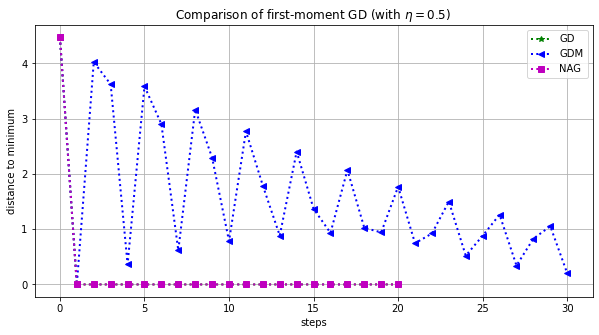

In [158]:
# Comparing GD with CM and NAG (for learning rate=eta2)
plt.close()
fig2, ax2 = plt.subplots(figsize=(10, 5))
# using eta2: GD converges slowly
gd_4 = gd(grad_quadra, init1, n_epochs=20, eta=eta2)
gd_5 = gd_with_mom(grad_quadra, init1, n_epochs=30, eta=eta2)
gd_6 = NAG(grad_quadra, init1, n_epochs=20, eta=eta2)
distance_to_min(ax2, gd_4, (0., 0.),'GD','g:*')
distance_to_min(ax2, gd_5, (0., 0.),'GDM','b:<')
distance_to_min(ax2, gd_6, (0., 0.),'NAG','m:s')

plt.grid()
plt.xlabel("steps")
plt.ylabel("distance to minimum")
plt.legend()
plt.title("Comparison of first-moment GD (with $\eta= %s$)" % eta2)

The ODG curve coincides with NAG's. In this case ($\eta=0.5$), NAG behaves just like ODG, while here again GDM takes its time.

Text(0.5, 1.0, 'Comparison of first-moment GD (with $\\eta= 1.01$)')

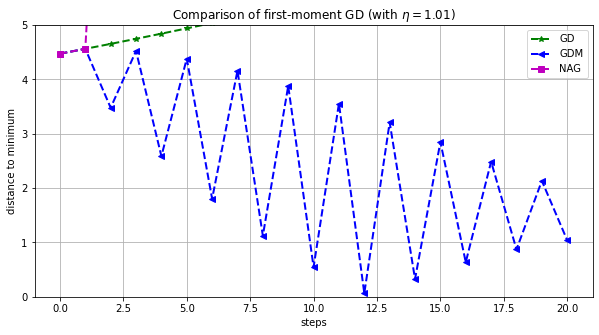

In [159]:
# Comparing GD with CM and NAG (for learning rate=eta4)

plt.close()
fig3, ax3 = plt.subplots(figsize=(10, 5))

# using eta4: GD diverges
gd_7 = gd(grad_quadra, init1, n_epochs=20, eta=eta4)
gd_8 = gd_with_mom(grad_quadra, init1, n_epochs=20, eta=eta4)
gd_9 = NAG(grad_quadra, init1, n_epochs=20, eta=eta4)

distance_to_min(ax3, gd_7, (0., 0.), 'GD', 'g--*')
distance_to_min(ax3, gd_8, (0., 0.), 'GDM', 'b--<')
distance_to_min(ax3, gd_9, (0., 0.), 'NAG', 'm--s')

plt.grid()
plt.ylim([0, 5])
plt.legend()
plt.xlabel("steps")
plt.ylabel("distance to minimum")
plt.title("Comparison of first-moment GD (with $\eta= %s$)" % eta4)

For $\eta=1.01$, both OGD and NAG diverge. However GDM converges!

Question: when is NAG useful ? Probably on a more complex, non-convex landscape.

### Using the second moment

 - RMSprop method

In [160]:
def rms_prop(grad, init, n_epochs=5000, eta=10**-3, beta=0.9,epsilon=10**-8,noise_strength=0):
    params=np.array(init)
    param_traj=np.zeros([n_epochs+1,2])
    param_traj[0,]=init#Import relevant packages
    grad_sq=0;
    for j in range(n_epochs):
        noise=noise_strength*np.random.randn(params.size)
        g=np.array(grad(params))+noise
        grad_sq=beta*grad_sq+(1-beta)*g*g
        v=eta*np.divide(g,np.sqrt(grad_sq+epsilon))
        params= params-v
        param_traj[j+1,]=params
    return param_traj

 - Adams method

In [161]:
def adams(grad, init, n_epochs=5000, eta=10**-4, gamma=0.9, beta=0.99,epsilon=10**-8,noise_strength=0):
    params=np.array(init)
    param_traj=np.zeros([n_epochs+1,2])
    param_traj[0,]=init
    v=0;
    grad_sq=0;
    for j in range(n_epochs):
        noise=noise_strength*np.random.randn(params.size)
        g=np.array(grad(params))+noise
        v=gamma*v+(1-gamma)*g
        grad_sq=beta*grad_sq+(1-beta)*g*g
        v_hat=v/(1-gamma)
        grad_sq_hat=grad_sq/(1-beta)
        params=params-eta*np.divide(v_hat,np.sqrt(grad_sq_hat+epsilon))
        param_traj[j+1,]=params
    return param_traj

Plotting the paths for GD, GDmom, NAG, RMSprop, ADAM with different starting points.

In [184]:
# commom parameters
Nsteps = 10**4
lr_l = 10**-3
lr_s = 10**-6

# starting points
init1 = np.array([4,3])
init2 = np.array([1.5,1.5])
init3=np.array([-1,4])
init4=np.array([-2,-4])

In [192]:
# Brevity is the soul of wit
gd_succinct = lambda init_, N_, eta_ : gd(grad_beales_function, init_, N_, 
                                      eta=eta_, noise_strength=0)
gdm_succinct = lambda init_, N_, eta_ : gd_with_mom(grad_beales_function, init_, N_, 
                                       eta=eta_, gamma=0.9, noise_strength=0)
NAG_succinct = lambda init_, N_, eta_ : NAG(grad_beales_function, init_, N_, eta=eta_, 
                                        gamma=0.9, noise_strength=0)
rms_succinct = lambda init_, N_, eta_ : rms_prop(grad_beales_function, init_, N_, eta=eta_,
                                             beta=0.9, epsilon=10**-8, noise_strength=0)
adams_succinct = lambda init_, N_, eta_ : adams(grad_beales_function, init_, N_, eta=eta_, 
                                            gamma=0.9, beta=0.99, epsilon=10**-8, noise_strength=0)

In [193]:
# Computing n° 1
gd_trajectory1  = gd_succinct(init1, Nsteps, lr_s)
gdm_trajectory1 = gdm_succinct(init1, Nsteps, lr_s)
NAG_trajectory1 = NAG_succinct(init1, Nsteps, lr_s)
rms_prop_trajectory1 = rms_succinct(init1, Nsteps, lr_l)
adam_trajectory1=adams_succinct(init1, Nsteps, lr_l)

# Computing  n° 3
gd_trajectory3 = gd_succinct(init3, 10**5, lr_s)
gdm_trajectory3 = gdm_succinct(init3, 10**5, lr_s)
NAG_trajectory3 = NAG_succinct(init3, Nsteps, lr_s)
rms_prop_trajectory3 = rms_succinct(init3, Nsteps, lr_l)
adam_trajectory3 = adams_succinct(init3, Nsteps, lr_l)

# Computing n° 4
gd_trajectory4 = gd_succinct(init4, Nsteps, lr_s)
gdm_trajectory4 = gdm_succinct(init4, Nsteps, lr_s)
NAG_trajectory4 = NAG_succinct(init4, Nsteps, lr_s)
rms_prop_trajectory4 = rms_succinct(init4, Nsteps, lr_l)
adam_trajectory4 = adams_succinct(init4, Nsteps, lr_l)

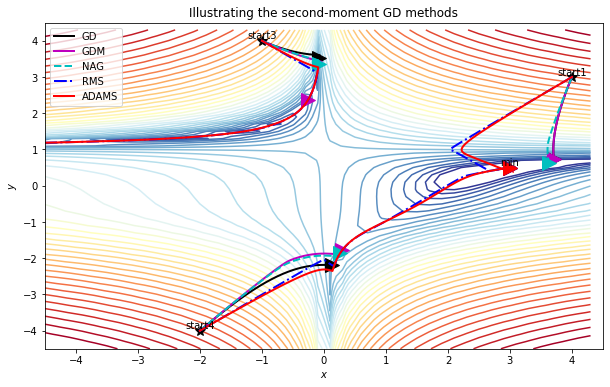

In [237]:
# Plotting 
plt.close()

fig1, ax1 = contour_beales_function()

# starting points
ax1.plot(init1[0], init1[1], 'k*', markersize=10)
ax1.text(init1[0], init1[1], s='start1', verticalalignment='bottom', 
         horizontalalignment='center')
ax1.plot(init3[0], init3[1], 'k*', markersize=10)
ax1.text(init3[0], init3[1], s='start3', verticalalignment='bottom', 
         horizontalalignment='center')
ax1.plot(init4[0], init4[1], 'k*', markersize=10)
ax1.text(init4[0], init4[1], s='start4',  verticalalignment='bottom', 
         horizontalalignment='center')

# n° 1
overlay_trajectory_contour_M(ax1,gd_trajectory1, 'GD','k')
overlay_trajectory_contour_M(ax1,gd_trajectory1, 'GDM','m')
overlay_trajectory_contour_M(ax1,NAG_trajectory1, 'NAG','c--')
overlay_trajectory_contour_M(ax1,rms_prop_trajectory1,'RMS', 'b-.')
overlay_trajectory_contour_M(ax1,adam_trajectory1,'ADAMS', 'r')

plt.legend(loc=2)

# n° 3
overlay_trajectory_contour_M(ax1, gd_trajectory3, 'GD', 'k')
overlay_trajectory_contour_M(ax1, gdm_trajectory3, 'GDM', 'm')
overlay_trajectory_contour_M(ax1, NAG_trajectory3, 'NAG', 'c--')
overlay_trajectory_contour_M(ax1, rms_prop_trajectory3, 'RMS', 'b-.')
overlay_trajectory_contour_M(ax1, adam_trajectory3, 'ADAMS', 'r')

# n° 4
overlay_trajectory_contour_M(ax1, gd_trajectory4, 'GD', 'k')
overlay_trajectory_contour_M(ax1, gdm_trajectory4, 'GDM', 'm')
overlay_trajectory_contour_M(ax1, NAG_trajectory4, 'NAG', 'c--')
overlay_trajectory_contour_M(ax1, rms_prop_trajectory4, 'RMS', 'b-.')
overlay_trajectory_contour_M(ax1, adam_trajectory4, 'ADAMS', 'r')

plt.title("Illustrating the second-moment GD methods")
plt.show()

In the first computation, GD hides behind GMD. In the third one, GDM hides behind NAG.

GD, GDM, and NAG tend to get stuck in flat places, while RMS and ADAM manage more often to leap further and find lower regions.

- Learning rate for the second-order methods

 Setting the learning rate at $10^{-6}$ for everyone yields:

In [254]:
# Computing n° 1
gd_lrs1  = gd_succinct(init1, Nsteps, lr_s)
gdm_lrs1 = gdm_succinct(init1, Nsteps, lr_s)
NAG_lrs1 = NAG_succinct(init1, Nsteps, lr_s)
rms_lrs1 = rms_succinct(init1, Nsteps, lr_s)
adam_lrs1=adams_succinct(init1, Nsteps, lr_s)

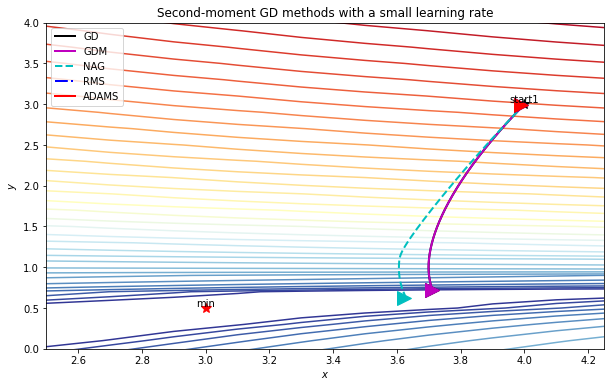

In [255]:
# Plotting 
plt.close()

fig, ax = contour_beales_function()
plt.xlim([2.5, 4.25])
plt.ylim([0, 4])

# starting points
ax.plot(init1[0], init1[1], 'k*', markersize=10)
ax.text(init1[0], init1[1], s='start1', verticalalignment='bottom', 
         horizontalalignment='center')

# n° 1
overlay_trajectory_contour_M(ax, gd_lrs1, 'GD','k')
overlay_trajectory_contour_M(ax, gd_lrs1, 'GDM','m')
overlay_trajectory_contour_M(ax, NAG_lrs1, 'NAG','c--')
overlay_trajectory_contour_M(ax, rms_lrs1,'RMS', 'b-.')
overlay_trajectory_contour_M(ax, adam_lrs1,'ADAMS', 'r')

plt.legend(loc=2)
plt.title("Second-moment GD methods with a small learning rate")
plt.show()

Here GD hides behind GDM, and both second-moment methods RMS and ADAMS stay at the starting point.

And with a learning rate $\eta =10^{-3}$:

In [265]:
# Computing n° 1
gd_lrl1  = gd_succinct(init1, 1, lr_l)
gdm_lrl1 = gdm_succinct(init1, 1, lr_l)
NAG_lrl1 = NAG_succinct(init1, 1, lr_l)
rms_lrl1 = rms_succinct(init1, Nsteps, lr_l)
adam_lrl1 = adams_succinct(init1, Nsteps, lr_l)

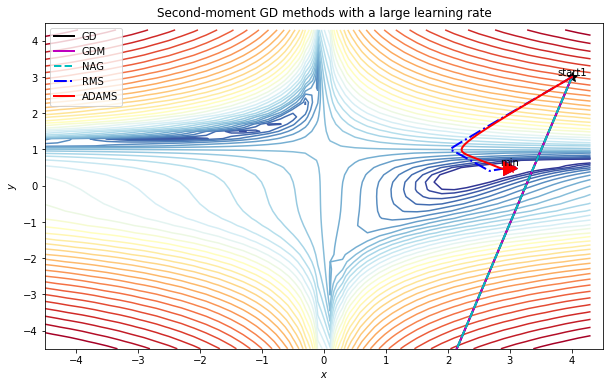

In [266]:
# Plotting 
plt.close()

fig, ax = contour_beales_function()
#plt.xlim([1.5, 4.25])
#plt.ylim([-1.5, 4.])

# starting points
ax.plot(init1[0], init1[1], 'k*', markersize=10)
ax.text(init1[0], init1[1], s='start1', verticalalignment='bottom', 
         horizontalalignment='center')

# n° 1
overlay_trajectory_contour_M(ax, gd_lrl1, 'GD','k')
overlay_trajectory_contour_M(ax, gd_lrl1, 'GDM','m')
overlay_trajectory_contour_M(ax, NAG_lrl1, 'NAG','c--')
overlay_trajectory_contour_M(ax, rms_lrl1,'RMS', 'b-.')
overlay_trajectory_contour_M(ax, adam_lrl1,'ADAMS', 'r')

plt.legend(loc=2)
plt.title("Second-moment GD methods with a large learning rate")
plt.show()

Here GD and GDM hide behind NAG. These three methods diverge with one step! Since the slope at the starting point is steep, a large learning rate make them blindly cross the dip from the beginning.

Result:
- With a small learning rate $\eta = 10^{-6}$ nor ADAM neither RMS leave their initial position... The other methods follow the slope until they reach their final positions;
- With a large learning rate $\eta=10^{-6}$, GD, GDM and NAG are out of control, while RMS and ADM turn out to be more consistent.        

## Conclusion

In this section we discovered some common gradient descent methods. We gained some insights on the crucial influence of the learning rate and the relative dependence to the local landscape. It seems that methods exploiting the second moment of the gradient are more reliable on complicated landscapes, as they usually cross flat regions instead of stopping, and don't diverge as easily as the first three methods for large learning rates. On the other hand, they are computationaly more expensive than the zeroth- or first-moment methods and unnecessary on simple potentials.